# 函数拟合

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NPY_MAXDIMS'] = '100'
class RBFnetwork(object):
    def __init__(self, hidden_size, r_w, r_c, r_sigma):
        self.h = hidden_size        #隐含层神经元个数
        self.w = 0                  #线性权值
        self.c = 0                  #神经元中心点
        self.sigma = 0              #高斯核宽度
        self.r = {"w":r_w, 
                  "c":r_c, 
                  "sigma":r_sigma}  #参数迭代的学习率
        self.errList = []           #误差列表
        self.n_iters = 0            #实际迭代次数
        self.tol = 1.0e-5           #最大容忍误差
        self.X = 0                  #训练集特征
        self.y = 0                  #训练集结果
        self.n_samples = 0          #训练集样本数量
        self.n_features = 0         #训练集特征数量
        self.y_features = 0
        self.y_samples = 0
    #计算径向基距离函数
    def guass(self, sigma, X, ci):
        #print(-np.linalg.norm((ci-X),axis=0))
        return np.exp(-np.linalg.norm((X-ci),axis=0)**2/(2*sigma**2))

    #将原数据高斯转化成新数据
    def change(self, sigma, X, c):
        newX = np.zeros((self.y_features, len(c)))
        #print(c,X)
        for i in range(len(c)):
            newX[:,i] = self.guass(sigma[i], X, c[i])
           # print(c[i])
        return newX

    #初始化参数
    def init(self):
        sigma = np.random.random((self.h, 1))               #(h,1)
        c = np.random.random((self.h, self.n_features))     #(h,n)
        w = np.random.random((self.h+1,1))                #(h+1,1)
        return sigma, c, w

    #给输出层的输入加一列截距项
    def addIntercept(self, X):
        return np.hstack((X,np.ones((self.y_features,1))))

    #计算整体误差
    def calSSE(self, prey, y):
        return 0.5*(np.linalg.norm(prey - y))**2

    #求L2范数的平方
    def l2(self, X, c):
        newX = np.zeros((self.y_features, len(c)))
        for i in range(len(c)):
            newX[:,i] = np.linalg.norm((X-c[i]))**2
        return newX
        #训练
    def train(self, X, y, iters):
        self.X = X
        self.y = y
        self.y_samples, self.y_features = y.shape
        self.n_samples, self.n_features = X.shape
        sigma, c, w = self.init()  
        error = 0#初始化参数
        for i in range(iters):
            ##正向计算过程
            deltaw=np.zeros(w.shape)
            deltasigma = np.zeros(sigma.shape)
            deltac2 = np.zeros((1,self.n_features))
            for k in range(self.n_samples):
                y_temp = y[k].reshape(-1,1)
                hi_output = self.change(sigma,X[k],c)              #隐含层输出(3,h)，即通过径向基函数的转换
                #print(hi_output)
                yi_input = self.addIntercept(hi_output)         #输出层输入(3,h+1)，因为是线性加权，故将偏置加入
                yi_output = np.dot(yi_input, w)                 #输出预测值(m,y_f)
                error = self.calSSE(yi_output, y_temp)               #计算误差

                deltaw += np.dot(yi_input.T, (yi_output-y_temp))      #(h+1,m)x(m,1)
                deltasigma += np.divide(np.multiply(np.dot(np.multiply(hi_output,self.l2(X[k],c)).T, \
                            (yi_output-y_temp)), w[:-1]), sigma**3)  #(h,m)x(m,1)
                deltac2 += np.dot((yi_output-y_temp).reshape(1,self.y_features),np.dot(hi_output, X[k]-c))
                
            w -= self.r['w']*deltaw/self.n_samples
            sigma -= self.r['sigma']*deltasigma/self.n_samples
            deltac1 = np.divide(w[:-1],sigma**2)
            deltac = np.dot(deltac1,deltac2) 
            c -= self.r['c']*deltac/self.n_samples
            if error < self.tol:
                break
            self.errList.append(error)                      #保存误差
            self.c = c
            self.w = w
            self.sigma = sigma
            self.n_iters = i
            #预测
    def predict(self, X):
        hi_output = self.change(self.sigma,X,self.c)    #隐含层输出(m,h)，即通过径向基函数的转换
        yi_input = self.addIntercept(hi_output)         #输出层输入(m,h+1)，因为是线性加权，故将偏置加入
        yi_output = np.dot(yi_input, self.w)            #输出预测值(m,1)
        return yi_output
    def plot_loss(self):
        plt.plot(self.errList)
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class BP_nn(object):
        def __init__(self,X,y,hidden_size,learning_rate):
            self.hidden_size = hidden_size        #隐含层神经元个数
            self.errList = []           #误差列表
            self.n_iters = 0            #实际迭代次数
            self.tol = 1.0e-5           #最大容忍误差
            self.X = X                 #训练集特征
            self.y = y                  #训练集结果
            self.learning_rate=learning_rate
            self.x_samples, self.x_features = self.X.shape
            self.y_samples, self.y_features = y.shape
            self.weights_input_hidden = np.random.rand(self.x_features, hidden_size)
            self.weights_hidden_output = np.random.rand(hidden_size, self.y_features)
            self.bias_y = np.full((1,self.y_features),-1).astype(np.float64)
            self.bias_h = np.full((1,self.hidden_size),-1).astype(np.float64);
            self.predicted_output=0
    
        def sigmoid(x):            
            return 1 / (1 + np.exp(-x))

        # Derivative of the sigmoid function
        def sigmoid_derivative(self,x):
            return x * (1 - x)
        
        def double_sigmoid(self,x):
            return (1-np.exp(-x))/(1+np.exp(-x))
        
        def double_sigmoid_derivative(self,x):
            return 0.5*(1-x**2)
        
        def linear(self,x):
            return x;

        def linear_derivative(self,x):
            return np.ones(x.shape)
        
        def relu(self,x):
            return np.maximum(0, x)
        
        def bias_adjust(self,num):
            bias = np.full(self.x_features,num).reshape(self.x_features,1)
            return bias
            
        # Function for forward propagation
        def forward_propagation(self):
            hidden_layer_input = np.dot(self.X, self.weights_input_hidden) + np.tile(self.bias_h,(self.X.shape[0], 1))
            hidden_layer_output = self.double_sigmoid(hidden_layer_input)
            output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output)+ np.tile(self.bias_y,(self.X.shape[0], 1))
            predicted_output = self.double_sigmoid(output_layer_input)
           # print(predicted_output)
            return hidden_layer_output, predicted_output
        
        # Function to calculate loss
        def calculate_loss(self,predicted_output):
            return np.mean(np.square(self.y - predicted_output))  # Mean Squared Error
        
        # Function for backward propagation #9x5
        def backward_propagation(self, hidden_layer_output, predicted_output):
            error = self.y - predicted_output#9x3
            d_predicted_output = error * self.double_sigmoid_derivative(predicted_output)#9x3
            #print(d_predicted_output)
            error_hidden_layer = d_predicted_output.dot(self.weights_hidden_output.T) #9x5
            d_hidden_layer = error_hidden_layer * self.double_sigmoid_derivative(hidden_layer_output) #9x5
        
            # Update weights
            self.weights_hidden_output += 2*hidden_layer_output.T.dot(d_predicted_output) * self.learning_rate/self.x_samples#5x3
            self.weights_input_hidden += 2*self.X.T.dot(d_hidden_layer) * self.learning_rate/self.x_samples #2x5
            for h in range(len(d_hidden_layer)):
                self.bias_h +=  2*d_hidden_layer[h]* self.learning_rate/self.x_samples
            for y in range(len(d_predicted_output)):
                self.bias_y +=  2*d_predicted_output[y]* self.learning_rate/self.x_samples
        
        # Function to train the neural network
        def train_neural_network(self,epochs):
        
            for epoch in range(epochs):
                hidden_layer_output, self.predicted_output= self.forward_propagation()
                loss = self.calculate_loss(self.predicted_output)
                self.backward_propagation(hidden_layer_output, self.predicted_output)
                if loss < self.tol:
                    break
                self.errList.append(loss)

        def predicted(self,X_p):
            hidden_layer_input_p = np.dot(X_p, self.weights_input_hidden)+np.tile(np.mean(bp.bias_h, axis=0), (X_p.shape[0], 1))
            hidden_layer_output_p = self.double_sigmoid(hidden_layer_input_p)
            output_layer_input_p = np.dot(hidden_layer_output_p, self.weights_hidden_output)+np.tile(np.mean(bp.bias_y, axis=0), (X_p.shape[0], 1))
            #print(hidden_layer_input_p)
            #print(hidden_layer_output)
            output = self.double_sigmoid(output_layer_input_p)
            return output
        # Function to plot the loss over epochs
        def plot_loss(self):
            plt.plot(self.errList)
            plt.title('Loss over epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.show()

In [7]:
def func(x, y):
    return 3 * (1-x)**2 * np.exp(-(x**2 + (y+1)**2)) -\
           10 * (x/5 - x**3 - y**5) * np.exp(-(x**2 + y**2)) -\
           1/3 * np.exp(-((x+1)**2 + y**2))

#------------------------------------------------------------
x = np.arange(-4, 4, 0.005)
y = np.arange(-4, 4, 0.005)

xx,yy = np.meshgrid(x, y)

zz = func(x, y)
xs=[]
ys=[]
zs=[]
SAMPLE_NUMBER   = [200,400,800,2000]
for i in range (len(SAMPLE_NUMBER)):
    xs.append(np.random.uniform(-4, 4, SAMPLE_NUMBER[i]))
    ys.append(np.random.uniform(-4, 4, SAMPLE_NUMBER[i]))
    zs.append(func(np.random.uniform(-4, 4, SAMPLE_NUMBER[i]),np.random.uniform(-4, 4, SAMPLE_NUMBER[i])))

x_train_f = np.array(list(zip(xs[0], ys[0])))
y_train_f = np.array([zs[0]]).reshape(-1,1)
x_train_400 = np.array(list(zip(xs[1], ys[1])))
y_train_400 = np.array([zs[1]]).reshape(-1,1)
x_train_800 = np.array(list(zip(xs[2], ys[2])))
y_train_800 = np.array([zs[2]]).reshape(-1,1)
x_train_2000 = np.array(list(zip(xs[3], ys[3])))
y_train_2000 = np.array([zs[3]]).reshape(-1,1)

# 不同采样数对BP的影响

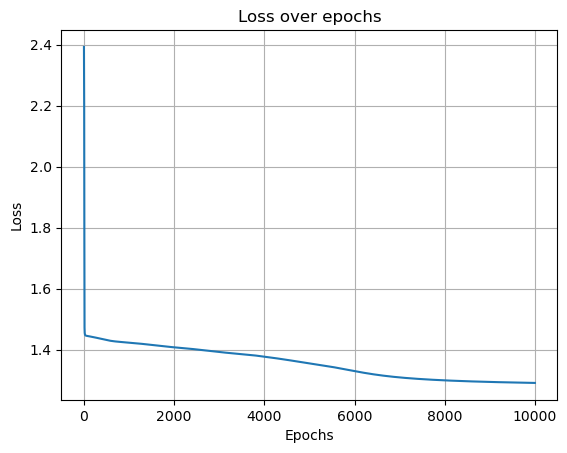

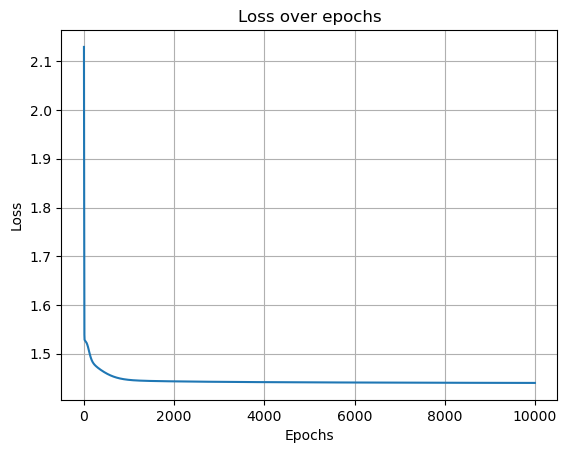

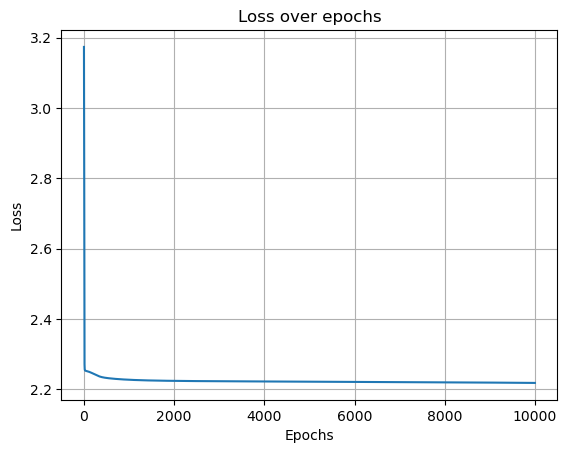

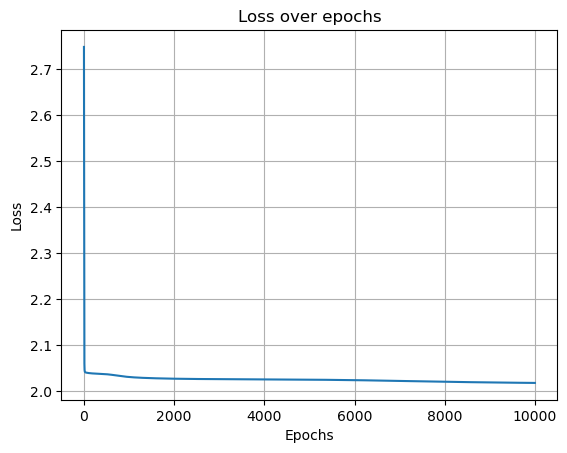

In [10]:
bp1 = BP_nn(x_train_f,y_train_f,6,0.3)
bp1.train_neural_network(10000)
bp1.plot_loss()
bp2 = BP_nn(x_train_400,y_train_400,6,0.3)
bp2.train_neural_network(10000)
bp2.plot_loss()
bp3 = BP_nn(x_train_800,y_train_800,6,0.3)
bp3.train_neural_network(10000)
bp3.plot_loss()
bp4 = BP_nn(x_train_2000,y_train_2000,6,0.3)
bp4.train_neural_network(10000)
bp4.plot_loss()

# 不同simga值的影响

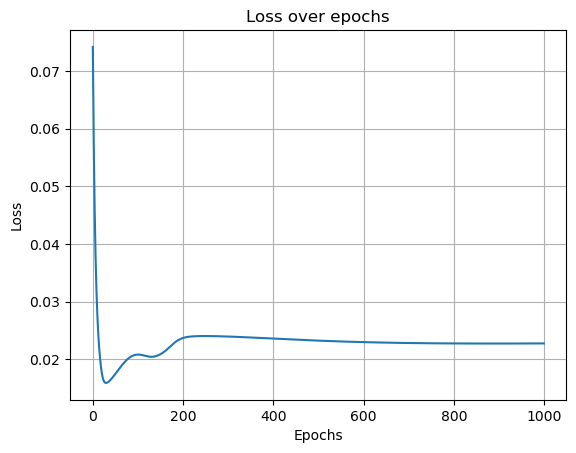

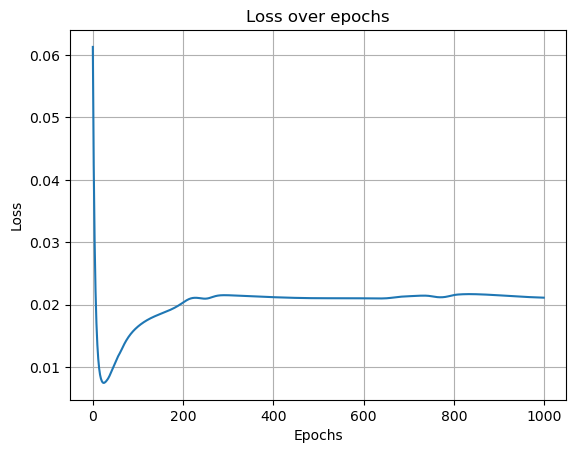

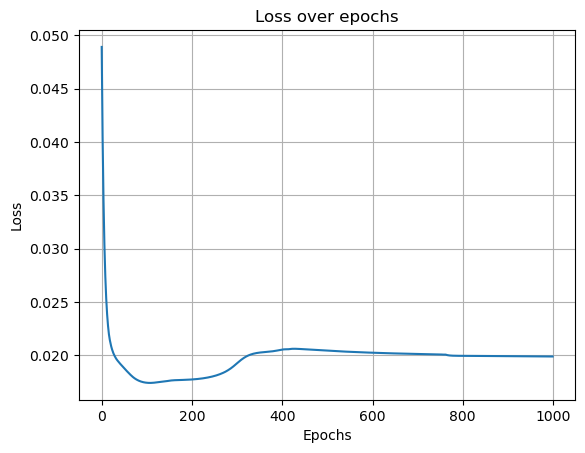

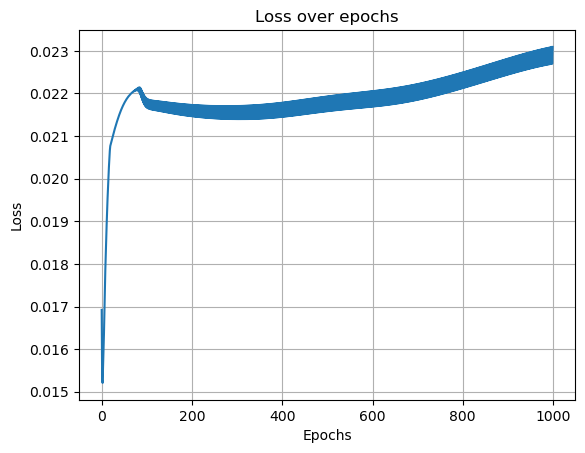

In [12]:
sigma=[0.01,0.1,1,5]
rbf1 = RBFnetwork(10, 0.1, 0.2, sigma[0])
rbf1.train(x_train_800, y_train_800, 1000)
rbf1.plot_loss()
rbf2 = RBFnetwork(10, 0.1, 0.2, sigma[1])
rbf2.train(x_train_800, y_train_800, 1000)
rbf2.plot_loss()
rbf3 = RBFnetwork(10, 0.1, 0.2, sigma[2])
rbf3.train(x_train_800, y_train_800, 1000)
rbf3.plot_loss()
rbf4 = RBFnetwork(10, 0.1, 0.2, sigma[3])
rbf4.train(x_train_800, y_train_800, 1000)
rbf4.plot_loss()

# 不同激活函数对BP的影响

Epoch [100/1000], Tanh Loss: 1.4813, ReLU Loss: 1.6503
Epoch [200/1000], Tanh Loss: 1.2542, ReLU Loss: 1.4401
Epoch [300/1000], Tanh Loss: 1.0512, ReLU Loss: 1.2369
Epoch [400/1000], Tanh Loss: 0.9059, ReLU Loss: 1.0711
Epoch [500/1000], Tanh Loss: 0.8012, ReLU Loss: 0.9539
Epoch [600/1000], Tanh Loss: 0.7190, ReLU Loss: 0.8736
Epoch [700/1000], Tanh Loss: 0.6502, ReLU Loss: 0.8173
Epoch [800/1000], Tanh Loss: 0.5914, ReLU Loss: 0.7730
Epoch [900/1000], Tanh Loss: 0.5386, ReLU Loss: 0.7284
Epoch [1000/1000], Tanh Loss: 0.4882, ReLU Loss: 0.6795


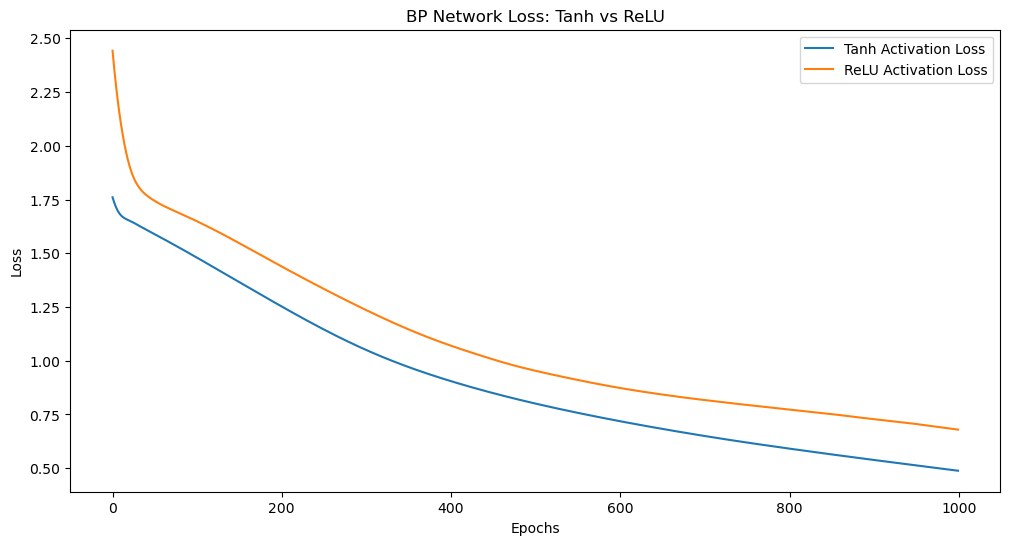

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 定义 BP 网络
class BPNet_Tanh(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(BPNet_Tanh, self).__init__()
        self.hidden = nn.Linear(in_features, hidden_features)
        self.activation = nn.Tanh()  # 使用 Tanh 激活函数
        self.output = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        hidden_out = self.activation(self.hidden(x))
        return self.output(hidden_out)

class BPNet_ReLU(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(BPNet_ReLU, self).__init__()
        self.hidden = nn.Linear(in_features, hidden_features)
        self.activation = nn.ReLU()  # 使用 ReLU 激活函数
        self.output = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        hidden_out = self.activation(self.hidden(x))
        return self.output(hidden_out)

# 定义 peaks 函数
def peaks(x, y):
    return 3 * (1 - x)**2 * np.exp(-(x**2) - (y + 1)**2) - 10 * (x / 5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x + 1)**2 - y**2)

# 生成训练样本
x_samples = np.random.uniform(-4, 4, 1000)
y_samples = np.random.uniform(-4, 4, 1000)
z_samples = peaks(x_samples, y_samples)

train_data = torch.tensor(np.vstack((x_samples, y_samples)).T, dtype=torch.float32)
train_labels = torch.tensor(z_samples, dtype=torch.float32).view(-1, 1)

# 定义模型
model_tanh = BPNet_Tanh(in_features=2, hidden_features=50, out_features=1)
model_relu = BPNet_ReLU(in_features=2, hidden_features=50, out_features=1)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer_tanh = optim.Adam(model_tanh.parameters(), lr=0.001)
optimizer_relu = optim.Adam(model_relu.parameters(), lr=0.001)

# 训练模型
epochs = 1000
loss_history_tanh = []
loss_history_relu = []

x_test, y_test = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
test_data = torch.tensor(np.vstack([x_test.ravel(), y_test.ravel()]).T, dtype=torch.float32)
z_true = peaks(x_test, y_test).reshape(-1, 1)

for epoch in range(epochs):
    # 训练 Tanh 模型
    optimizer_tanh.zero_grad()
    outputs_tanh = model_tanh(train_data)
    loss_tanh = criterion(outputs_tanh, train_labels)
    loss_tanh.backward()
    optimizer_tanh.step()

    # 训练 ReLU 模型
    optimizer_relu.zero_grad()
    outputs_relu = model_relu(train_data)
    loss_relu = criterion(outputs_relu, train_labels)
    loss_relu.backward()
    optimizer_relu.step()

    # 记录损失
    loss_history_tanh.append(loss_tanh.item())
    loss_history_relu.append(loss_relu.item())

    # 输出每 100 次迭代的损失
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Tanh Loss: {loss_tanh.item():.4f}, '
              f'ReLU Loss: {loss_relu.item():.4f}')

# 绘制 Tanh 和 ReLU 的损失曲线对比
plt.figure(figsize=(12, 6))
plt.plot(loss_history_tanh, label='Tanh Activation Loss')
plt.plot(loss_history_relu, label='ReLU Activation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BP Network Loss: Tanh vs ReLU')
plt.legend()
plt.show()